In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import numpy as np
import os
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import joblib

In [3]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00


In [5]:


# Set directories for saving models and loading datasets
model_dir = '/content/drive/My Drive/Capstone/Version7.7'
data_path = '/content/drive/My Drive/Capstone/News_cleaned.csv'
output_data_path = '/content/drive/My Drive/Capstone/News_Features_Engineered_Dataset.csv'

os.makedirs(model_dir, exist_ok=True)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using device: {device}")


# Load the dataset
data = pd.read_csv(data_path)

# Step 1: Drop unnecessary columns
columns_to_drop = ['URL', 'Entities Mentioned', 'Entities in Abstract']
data = data.drop(columns=columns_to_drop, errors='ignore')
print("After dropping columns:\n", data.head(10))

# Step 2: BERT Embeddings for Title and Abstract
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)  # Move model to MPS

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to MPS
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()  # Move back to CPU
    return embedding.flatten().tolist()  # Convert to list

data['BERT-Embeddings'] = data.apply(lambda row: get_bert_embedding(row['Title'] + " " + row['Abstract']), axis=1)
print("After BERT Embeddings:\n", data[['BERT-Embeddings']].head(10))

# Step 3: TF-IDF Embeddings for Title and Abstract
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features as needed
tfidf_embeddings = tfidf_vectorizer.fit_transform(data['Title'] + " " + data['Abstract']).toarray()
data['TF-IDF Embeddings'] = tfidf_embeddings.tolist()  # Convert to list for each row
joblib.dump(tfidf_vectorizer, os.path.join(model_dir, 'tfidf_vectorizer.pkl'))  # Save the TF-IDF model
print("After TF-IDF Embeddings:\n", data[['TF-IDF Embeddings']].head(10))

# Step 4: LDA Topic Modeling on Title and Abstract
lda_model = LatentDirichletAllocation(n_components=10, random_state=0)  # Adjust n_components as needed
lda_topics = lda_model.fit_transform(tfidf_embeddings)
data['LDA Embeddings'] = lda_topics.tolist()  # Convert to list
joblib.dump(lda_model, os.path.join(model_dir, 'lda_model.pkl'))  # Save the LDA model
print("After LDA Embeddings:\n", data[['LDA Embeddings']].head(10))

# Step 5: Doc2Vec Embeddings for Document Similarity
documents = [TaggedDocument(words=(row['Title'] + " " + row['Abstract']).split(), tags=[i]) for i, row in data.iterrows()]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)  # Adjust vector_size as needed
data['Doc2vec Embeddings'] = data.apply(lambda row: doc2vec_model.infer_vector((row['Title'] + " " + row['Abstract']).split()).tolist(), axis=1)
doc2vec_model.save(os.path.join(model_dir, 'doc2vec_model'))  # Save the Doc2Vec model
print("After Doc2Vec Embeddings:\n", data[['Doc2vec Embeddings']].head(10))

# Step 6: K-means Clustering on Category and Subcategory
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(data['Category'])
subcategory_labels = label_encoder.fit_transform(data['Subcategory'])

# Combine the encoded Category and Subcategory
category_subcategory_combined = np.column_stack((category_labels, subcategory_labels))

# Using the K-means score method to find the optimal number of clusters
scores = []
for k in range(2, 70):  # Testing clusters from 2 to 70
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(category_subcategory_combined)
    scores.append(kmeans.score(category_subcategory_combined))

optimal_k = scores.index(max(scores)) + 2  # Selecting the k with the highest score
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(category_subcategory_combined)
data['K-means Clusters'] = kmeans.predict(category_subcategory_combined)
joblib.dump(kmeans, os.path.join(model_dir, 'kmeans_model.pkl'))  # Save the K-means model

# Generate cluster centroid embeddings and assign them
centroids = kmeans.cluster_centers_
data['K-means Embeddings'] = data['K-means Clusters'].apply(lambda x: centroids[x].astype(np.float32).tolist())  # Convert to list
print("After K-means Clustering:\n", data[['K-means Clusters', 'K-means Embeddings']].head(10))

# Final check for all embeddings to ensure they are in the correct format
print("Final Data with Embeddings:\n", data.head(10))

# Save the processed dataset with all new embeddings columns
data.to_csv(output_data_path, index=False)

Using device: cuda
After dropping columns:
    News ID   Category               Subcategory  \
0   N88753  lifestyle           lifestyleroyals   
1   N45436       news  newsscienceandtechnology   
2   N23144     health                weightloss   
3   N93187       news                 newsworld   
4   N75236     health                    voices   
5   N99744     health                   medical   
6  N124534     sports               footballnfl   
7   N51947       news  newsscienceandtechnology   
8   N59220    weather         weathertopstories   
9   N17957     health                weightloss   

                                               Title  \
0  the brands queen elizabeth, prince charles, an...   
1    walmart slashes prices on last-generation ipads   
2                      50 worst habits for belly fat   
3  the cost of trump's aid freeze in the trenches...   
4  i was an nba wife. here's how it affected my m...   
5  how to get rid of skin tags, according to a de...   
6 

In [6]:
import pandas as pd
import re

# Load the behavior dataset
behavior_data_path = '/content/drive/My Drive/Capstone/cleaned_behavior_dataset.csv'
behavior_data = pd.read_csv(behavior_data_path)

# Columns to retain
columns_to_keep = ['User ID', 'Displayed News List', 'Clicked News IDs', 'Not-Clicked News IDs']

# Drop all columns except the ones specified
behavior_data = behavior_data[columns_to_keep]

# Check and display the data types of each column before processing
print("Data types before conversion:\n", behavior_data.dtypes)

# Function to convert to comma-separated and handle concatenated news IDs
def convert_to_comma_separated(value):
    if pd.isna(value):
        return ""  # Handle NaN values
    # Remove brackets, quotes, spaces, and any unwanted characters
    value = re.sub(r"[\[\]'\" ]", "", value)
    # Add comma between concatenated IDs using regex to find patterns like 'N[digits]N[digits]'
    value = re.sub(r"(N\d+)(?=N\d+)", r"\1,", value)
    return value

# Apply conversion to 'Displayed News List', 'Clicked News IDs', and 'Not-Clicked News IDs'
behavior_data['Displayed News List'] = behavior_data['Displayed News List'].apply(convert_to_comma_separated)
behavior_data['Clicked News IDs'] = behavior_data['Clicked News IDs'].apply(convert_to_comma_separated)
behavior_data['Not-Clicked News IDs'] = behavior_data['Not-Clicked News IDs'].apply(convert_to_comma_separated)

# Validation function to confirm no concatenated IDs remain
def check_concatenated_ids(column):
    pattern = r"N\d+N\d+"  # Pattern to detect concatenated IDs
    concatenated_ids = behavior_data[column].str.contains(pattern, regex=True).sum()
    return concatenated_ids == 0

# Check for concatenated IDs in all relevant columns
columns_to_check = ['Displayed News List', 'Clicked News IDs', 'Not-Clicked News IDs']
for col in columns_to_check:
    if check_concatenated_ids(col):
        print(f"No concatenated IDs found in '{col}'.")
    else:
        print(f"Concatenated IDs detected in '{col}' after processing.")

# Ensure 'Clicked News IDs' and 'Not-Clicked News IDs' have the same data type as 'Displayed News List'
displayed_news_type = behavior_data['Displayed News List'].dtype
behavior_data['Clicked News IDs'] = behavior_data['Clicked News IDs'].astype(displayed_news_type)
behavior_data['Not-Clicked News IDs'] = behavior_data['Not-Clicked News IDs'].astype(displayed_news_type)

# Check and display the data types after conversion to confirm changes
print("Data types after conversion:\n", behavior_data.dtypes)

# Display the first few rows to confirm the dataset structure
print("Processed Behavior Dataset:\n", behavior_data.head(10))

# Save the processed dataset if needed
output_behavior_data_path = '/content/drive/My Drive/Capstone/processed_behavior_dataset.csv'
behavior_data.to_csv(output_behavior_data_path, index=False)

Data types before conversion:
 User ID                 object
Displayed News List     object
Clicked News IDs        object
Not-Clicked News IDs    object
dtype: object
No concatenated IDs found in 'Displayed News List'.
No concatenated IDs found in 'Clicked News IDs'.
No concatenated IDs found in 'Not-Clicked News IDs'.
Data types after conversion:
 User ID                 object
Displayed News List     object
Clicked News IDs        object
Not-Clicked News IDs    object
dtype: object
Processed Behavior Dataset:
    User ID                                Displayed News List  \
0   U87243  N8668,N39081,N65259,N79529,N73408,N43615,N2937...   
1  U598644  N56056,N8726,N70353,N67998,N83823,N111108,N107...   
2  U532401  N128643,N87446,N122948,N9375,N82348,N129412,N5...   
3  U593596  N31043,N39592,N4104,N8223,N114581,N92747,N1207...   
4  U239687  N65250,N122359,N71723,N53796,N41663,N41484,N11...   
5  U521853  N8668,N29136,N128643,N9740,N9375,N52911,N12090...   
6  U687515               

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import pickle
import umap
import time
from ast import literal_eval
from collections import defaultdict
import re

# Directory paths
model_dir = '/content/drive/My Drive/Capstone/Version7.7'
data_path = '/content/drive/My Drive/Capstone/News_Features_Engineered_Dataset.csv'
behavior_data_path = '/content/drive/My Drive/Capstone/processed_behavior_dataset.csv'
user_profiles_path = os.path.join(model_dir, 'user_profiles.pkl')
os.makedirs(model_dir, exist_ok=True)

# Device setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 64  # Process 64 users per batch
NUM_HEADS = 32   # Number of attention heads
HIDDEN_DIM = 512
LEARNING_RATE = 2.5e-5
EARLY_STOP_TRIGGER = 5
EMBED_DIM = 512
DROPOUT_RATE = 0.4

# Helper function to standardize News ID format
def standardize_news_id(nid):
    """Standardize News ID by removing extra spaces."""
    return re.sub(r"\s+", "", nid) if isinstance(nid, str) else nid

# Helper function to standardize User ID format
def standardize_user_id(uid):
    """Standardize User ID by removing extra spaces and applying a consistent format."""
    return re.sub(r"\s+", "", str(uid)) if isinstance(uid, (str, int)) else uid

# Step 1: Load and preprocess news embeddings with UMAP
print("Step 1: Loading and reducing news embeddings with UMAP.")
data = pd.read_csv(data_path)

# Standardize News IDs
data['News ID'] = data['News ID'].apply(standardize_news_id)

# Load and process embeddings with error counting
def load_embedding(column):
    error_count = 0
    def parse_embedding(x):
        nonlocal error_count
        try:
            return np.array(literal_eval(x), dtype=np.float32)
        except (ValueError, SyntaxError):
            error_count += 1
            return np.zeros(target_embedding_size, dtype=np.float32)

    processed_embeddings = data[column].apply(parse_embedding)
    print(f"Number of errors encountered in column '{column}': {error_count}")
    return processed_embeddings

target_embedding_size = 768
data['BERT-Embeddings'] = load_embedding('BERT-Embeddings')

def pad_or_truncate_np_array(array, target_size):
    if len(array.shape) != 1:
        raise ValueError(f"Expected 1D embeddings, got shape: {array.shape}")
    current_size = array.shape[0]
    if current_size > target_size:
        return array[:target_size]
    elif current_size < target_size:
        return np.pad(array, (0, target_size - current_size))
    return array

data['BERT-Embeddings'] = data['BERT-Embeddings'].apply(lambda x: pad_or_truncate_np_array(x, target_embedding_size))

embedding_matrix = np.hstack([
    np.vstack(data['BERT-Embeddings'].values),
])

scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embedding_matrix)

# Set UMAP parameters
UMAP_NEIGHBORS = 140
UMAP_MIN_DIST = 0.1
UMAP_COMPONENTS = 512
UMAP_RANDOM_STATE = None
UMAP_N_JOBS = -1

umap_model = umap.UMAP(
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    n_components=UMAP_COMPONENTS,
    random_state=UMAP_RANDOM_STATE,
    n_jobs=UMAP_N_JOBS
)

# Fit and transform normalized embeddings
reduced_embeddings = umap_model.fit_transform(normalized_embeddings)

# Convert to tensors
data['combined_embedding'] = [torch.tensor(embedding, dtype=torch.float32) for embedding in reduced_embeddings]

# Create news embeddings map
news_embeddings_map = {row['News ID']: row['combined_embedding'] for _, row in data.iterrows()}

# Step 2: Generate and save/load user profiles
print("Step 2: Checking for existing user profiles.")

# Load behavior data first
behavior_df = pd.read_csv(behavior_data_path, usecols=['User ID', 'Displayed News List', 'Clicked News IDs', 'Not-Clicked News IDs'])
behavior_df['User ID'] = behavior_df['User ID'].apply(standardize_user_id)
behavior_df['Clicked News IDs'] = behavior_df['Clicked News IDs'].apply(
    lambda x: [standardize_news_id(nid) for nid in x.split(',')] if isinstance(x, str) else []
)
behavior_df['Not-Clicked News IDs'] = behavior_df['Not-Clicked News IDs'].apply(
    lambda x: [standardize_news_id(nid) for nid in x.split(',')] if isinstance(x, str) else []
)

# Create user_clicks dictionary
user_clicks = defaultdict(lambda: {'clicked': [], 'not_clicked': []})
for _, row in behavior_df.iterrows():
    user_id = row['User ID']
    user_clicks[user_id]['clicked'].extend(row['Clicked News IDs'])
    user_clicks[user_id]['not_clicked'].extend(row['Not-Clicked News IDs'])

if os.path.exists(user_profiles_path):
    print("Loading user profiles from saved file.")
    with open(user_profiles_path, 'rb') as f:
        user_profiles = pickle.load(f)
else:
    print("Generating new user profiles.")
    user_profiles = {}
    for user_id, interactions in user_clicks.items():
        clicked_embeddings = [news_embeddings_map[cid] for cid in interactions['clicked'] if cid in news_embeddings_map]
        not_clicked_embeddings = [news_embeddings_map[ncid] for ncid in interactions['not_clicked'] if ncid in news_embeddings_map]

        preference_profile = torch.stack(clicked_embeddings).mean(dim=0) if clicked_embeddings else torch.zeros(512)
        non_preference_profile = torch.stack(not_clicked_embeddings).mean(dim=0) if not_clicked_embeddings else torch.zeros(512)
        user_profiles[user_id] = {'preference_profile': preference_profile, 'non_preference_profile': non_preference_profile}

    with open(user_profiles_path, 'wb') as f:
        pickle.dump(user_profiles, f)
    print(f"User profiles saved to {user_profiles_path}")

Using device: cuda
Step 1: Loading and reducing news embeddings with UMAP.
Number of errors encountered in column 'BERT-Embeddings': 0
Step 2: Checking for existing user profiles.
Loading user profiles from saved file.


Streaming output truncated to the last 5000 lines.
Processed batch 75480
Processed batch 75481
Processed batch 75482
Processed batch 75483
Processed batch 75484
Processed batch 75485
Processed batch 75486
Processed batch 75487
Processed batch 75488
Processed batch 75489
Processed batch 75490
Processed batch 75491
Processed batch 75492
Processed batch 75493
Processed batch 75494
Processed batch 75495
Processed batch 75496
Processed batch 75497
Processed batch 75498
Processed batch 75499
Processed batch 75500
Processed batch 75501
Processed batch 75502
Processed batch 75503
Processed batch 75504
Processed batch 75505
Processed batch 75506
Processed batch 75507
Processed batch 75508
Processed batch 75509
Processed batch 75510
Processed batch 75511
Processed batch 75512
Processed batch 75513
Processed batch 75514
Processed batch 75515
Processed batch 75516
Processed batch 75517
Processed batch 75518
Processed batch 75519
Processed batch 75520
Processed batch 75521
Processed batch 75522
Pro

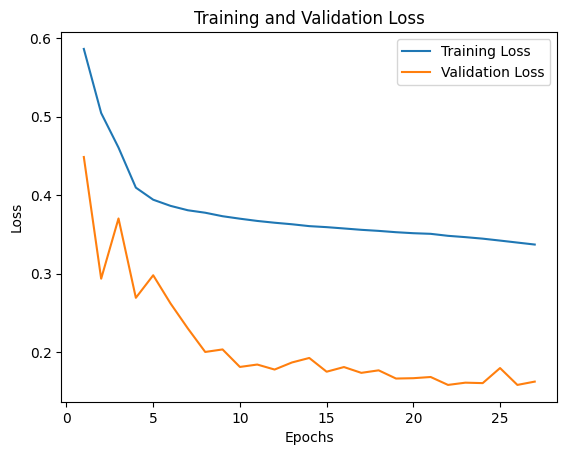

In [10]:
# Step 3: Define the model
class MultiHeadAttentionModel(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout_rate):
        """
        Multi-head attention model with feed-forward layers and dropout.

        Args:
            embed_dim (int): Dimension of input embeddings.
            num_heads (int): Number of attention heads.
            hidden_dim (int): Dimension of hidden layers in the feed-forward network.
            dropout_rate (float): Dropout rate for regularization.
        """
        super(MultiHeadAttentionModel, self).__init__()
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.linear1 = nn.Linear(embed_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.output_layer = nn.Linear(hidden_dim // 4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_news_pairs):
        """
        Forward pass for the model.

        Args:
            user_news_pairs (Tensor): Input tensor of shape (batch_size, 2, embed_dim).

        Returns:
            Tensor: Predicted scores for the input pairs.
        """
        # Multi-head attention
        attn_output, _ = self.multihead_attention(user_news_pairs, user_news_pairs, user_news_pairs)
        attn_output = attn_output.mean(dim=1)

        # Fully connected layers with dropout and activation
        x = self.dropout(self.relu(self.linear1(attn_output)))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.dropout(self.relu(self.linear3(x)))

        # Output layer
        return self.sigmoid(self.output_layer(x))


# Initialize model, optimizer, and scheduler with updated hyperparameters
print("Initializing model, optimizer, and scheduler.")
model = MultiHeadAttentionModel(embed_dim=EMBED_DIM, num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=EARLY_STOP_TRIGGER, verbose=True)  # Learning rate scheduler

# Print model structure to verify
print(model)

# Split user profiles into training and validation sets
train_user_ids, val_user_ids = train_test_split(list(user_profiles.keys()), test_size=0.05, random_state=42)
train_user_profiles = {uid: user_profiles[uid] for uid in train_user_ids}
val_user_profiles = {uid: user_profiles[uid] for uid in val_user_ids}

# Training loop with validation loss per epoch
print("Starting Training Loop with Validation Loss Monitoring.")
best_loss = float('inf')
trigger_count = 0
train_losses = []
validation_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    start_time = time.time()

    batch_inputs, batch_labels = [], []

    # Training phase
    for i, (user_id, profiles) in enumerate(train_user_profiles.items(), 1):
        # Get user preference and non-preference profile embeddings
        preference_profile = profiles['preference_profile'].to(device)
        non_preference_profile = profiles['non_preference_profile'].to(device)

        # Get clicked and not-clicked news IDs
        clicked_news_ids = user_clicks[user_id]['clicked']
        not_clicked_news_ids = user_clicks[user_id]['not_clicked']

        # Apply under-sampling
        if len(clicked_news_ids) > len(not_clicked_news_ids):
            clicked_news_ids = np.random.choice(clicked_news_ids, size=len(not_clicked_news_ids), replace=False)
        elif len(not_clicked_news_ids) > len(clicked_news_ids):
            not_clicked_news_ids = np.random.choice(not_clicked_news_ids, size=len(clicked_news_ids), replace=False)

        # Create input pairs for clicked news with preference profile (Label 1)
        for clicked_news_id in clicked_news_ids:
            if clicked_news_id in news_embeddings_map:
                news_embedding = news_embeddings_map[clicked_news_id].to(device)
                input_pair = torch.stack([preference_profile, news_embedding]).unsqueeze(0)  # Shape (1, 2, 512)
                batch_inputs.append(input_pair)
                batch_labels.append(torch.tensor([1.0], device=device))  # Label as clicked (1)

        # Create input pairs for not-clicked news with non-preference profile (Label 0)
        for not_clicked_news_id in not_clicked_news_ids:
            if not_clicked_news_id in news_embeddings_map:
                news_embedding = news_embeddings_map[not_clicked_news_id].to(device)
                input_pair = torch.stack([non_preference_profile, news_embedding]).unsqueeze(0)  # Shape (1, 2, 512)
                batch_inputs.append(input_pair)
                batch_labels.append(torch.tensor([0.0], device=device))  # Label as not-clicked (0)

        # Process batch if full or at the end of profiles
        if len(batch_inputs) >= BATCH_SIZE or i == len(train_user_profiles):
            inputs = torch.cat(batch_inputs).to(device)  # Shape (BATCH_SIZE, 2, EMBED_DIM)
            labels = torch.stack(batch_labels).view(-1, 1).to(device)
            batch_inputs, batch_labels = [], []

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1
            print(f"Processed batch {batch_count}")

    avg_train_loss = epoch_loss / batch_count
    train_losses.append(avg_train_loss)
    scheduler.step(avg_train_loss)
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f} | Time: {elapsed_time:.2f}s")

    # Validation phase with batching
    model.eval()
    validation_loss = 0.0
    validation_pair_count = 0

    batch_inputs, batch_labels = [], []

    with torch.no_grad():
        for user_id, profiles in val_user_profiles.items():
            # Get the user's preference and non-preference profiles
            preference_profile = profiles['preference_profile'].to(device)
            non_preference_profile = profiles['non_preference_profile'].to(device)

            clicked_news_ids = user_clicks[user_id]['clicked']
            not_clicked_news_ids = user_clicks[user_id]['not_clicked']

            # Process clicked news items with preference profile
            for clicked_news_id in clicked_news_ids:
                if clicked_news_id in news_embeddings_map:
                    news_embedding = news_embeddings_map[clicked_news_id].to(device)
                    input_pair = torch.stack([preference_profile, news_embedding]).unsqueeze(0)  # Shape (1, 2, 512)
                    batch_inputs.append(input_pair)
                    batch_labels.append(torch.tensor([1.0], device=device))  # Label as clicked (1)

            # Process not-clicked news items with non-preference profile
            for not_clicked_news_id in not_clicked_news_ids:
                if not_clicked_news_id in news_embeddings_map:
                    news_embedding = news_embeddings_map[not_clicked_news_id].to(device)
                    input_pair = torch.stack([non_preference_profile, news_embedding]).unsqueeze(0)  # Shape (1, 2, 512)
                    batch_inputs.append(input_pair)
                    batch_labels.append(torch.tensor([0.0], device=device))  # Label as not-clicked (0)

            # Process batch if full or at the end of users
            if len(batch_inputs) >= BATCH_SIZE or user_id == list(val_user_profiles.keys())[-1]:
                inputs = torch.cat(batch_inputs).to(device)  # Shape (BATCH_SIZE, 2, EMBED_DIM)
                labels = torch.stack(batch_labels).view(-1, 1).to(device)
                batch_inputs, batch_labels = [], []

                # Forward pass and compute loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * labels.size(0)  # Accumulate total loss
                validation_pair_count += labels.size(0)

    # Compute average validation loss
    avg_validation_loss = validation_loss / validation_pair_count
    validation_losses.append(avg_validation_loss)
    print(f"Epoch {epoch + 1} Validation Loss: {avg_validation_loss:.4f}")

    # Save model if validation loss improved
    if avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        trigger_count = 0
        model_save_path = os.path.join(model_dir, f"best_model_epoch_{epoch + 1}.pt")
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model updated and saved for epoch {epoch + 1}")
    else:
        trigger_count += 1
        if trigger_count >= EARLY_STOP_TRIGGER:
            print("Early stopping triggered.")
            break

# Plot validation and training losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()